<a href="https://colab.research.google.com/github/Geopalut/AdversarialML/blob/master/basic_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Attacking a basic convnet 

In this notebook I will experiment with different adversaries using a basic convolutionnal neural network trained on CIFAR10 as the target. The notebook is organised as follows:

1. Building and training a basic net  
2. Building adversarial examples using FGSM
3. Building adversarial examples using a multiple step PGD
4. Trying to improve the defense of the network using adversarial training. 


### 1. The target network

For this example I build a basic convolutional neural network with three convolutionnal layers and two dense layers. 

There is also some light data processing to import CIFAR 10 images.

In [1]:
# Initial imports
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np


#### Importing the data:
I use the torchvision data loader to download the CIFAR 10 dataset. Images are of size 32x32 pixels with 3 channels (RGB) each channel have values in [0,1]. I transform it to [-1,1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Setting up 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Checking that a GPU is allocated to this session 
# if "cpu" appears, choose "GPU" in runtime > change runtime type > accelerator

print(device)

cuda:0


Visualizing a sample of images.
Images are blurry yet recognizable.

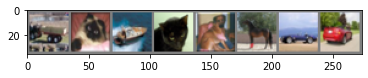

truck   cat  ship   cat   dog horse   car   car


In [54]:
# functions to show an image (source : pytorch cifar_10 tutorial)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

#### Defining the convolutional network. 

Next we create the conv net that will be targeted. 


In [4]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, 
                               padding=1) # adding 1 pixel of O padding on both sides 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, 
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                               padding=1)
        self.fc1 = nn.Linear(in_features= 32 * 4 * 4, out_features=128, bias=True)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening the output so it can be used in a dense layer
        x = x.view(x.size(0), -1) # resize to (size of the batch, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # no need to compute the softmax, it is part of the loss
        # criterion (cross_entropy)
        return x


net = ConvNet()
net = net.to(device) # using the gpu

Defining the optimizer and the loss function.
I used cross entropy for the loss and Adam for the optimizer.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001) # default parameters


Training loop 

In [57]:
for epoch in range(10):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # sending them to the GPU at each step
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.727
[1,  4000] loss: 1.459
[1,  6000] loss: 1.348
[2,  2000] loss: 1.218
[2,  4000] loss: 1.176
[2,  6000] loss: 1.126
[3,  2000] loss: 1.060
[3,  4000] loss: 1.026
[3,  6000] loss: 1.016
[4,  2000] loss: 0.937
[4,  4000] loss: 0.956
[4,  6000] loss: 0.962
[5,  2000] loss: 0.876
[5,  4000] loss: 0.894
[5,  6000] loss: 0.899
[6,  2000] loss: 0.817
[6,  4000] loss: 0.838
[6,  6000] loss: 0.852
[7,  2000] loss: 0.779
[7,  4000] loss: 0.809
[7,  6000] loss: 0.801
[8,  2000] loss: 0.734
[8,  4000] loss: 0.768
[8,  6000] loss: 0.776
[9,  2000] loss: 0.702
[9,  4000] loss: 0.745
[9,  6000] loss: 0.757
[10,  2000] loss: 0.679
[10,  4000] loss: 0.690
[10,  6000] loss: 0.738
Finished Training


In [58]:
model_PATH = './cifar_conv_net.pth'

# saving the model 

torch.save(net.state_dict(), model_PATH)

# loading the model

# net = ConvNet()
# net.load_state_dict(torch.load(model_PATH))

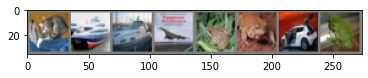

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog
Predicted:    cat  ship  ship plane  deer  frog   car  frog


In [59]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

outputs = net(images.cuda())

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

In [60]:
# network performances:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


In [61]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 73 %
Accuracy of   car : 86 %
Accuracy of  bird : 60 %
Accuracy of   cat : 55 %
Accuracy of  deer : 48 %
Accuracy of   dog : 52 %
Accuracy of  frog : 71 %
Accuracy of horse : 71 %
Accuracy of  ship : 75 %
Accuracy of truck : 76 %


We now have a simple model to attack. The performances are far from perfect but its enough to experiment with basic attacks.

### 2. FGSM adversary

This is a whitebox atttack where I have the full model and am able to compute the loss and its gradient to find the optimal direction in which to perturb the input.

In [62]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.cuda(), labels.cuda()
images.requires_grad = True
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

loss = criterion(outputs, labels)
gradients = torch.autograd.grad(outputs=loss, inputs=images)

Predicted:    cat  ship  ship plane  deer  frog   car  frog


In [63]:
gradients[0].shape

torch.Size([8, 3, 32, 32])

In [6]:
def fgsm_attack(model, x_nat, y_nat, epsilon): 
  """ Given a set of natural examples and labels, returns a set of adversarial 
  examples within epsilon of their natural counterpart in l_inf norm.
  """
  # possible to add the loss function as a parameter

  # for each natural image I am interested in the gradient in the input space
  x_nat.requires_grad = True
  outputs = model(x_nat)
  loss = criterion(outputs, y_nat)
  gradients = torch.autograd.grad(outputs=loss, inputs=x_nat)[0]

  # Collect the element-wise sign of the data gradient
  grad_sign = gradients.sign()
  # Create the perturbed images by adjusting each pixel of the input image
  x_adv = x_nat + epsilon*grad_sign
  # Adding clipping to maintain [-1,1] range
  perturbed_image = torch.clamp(x_adv, -1, 1)
  # Return the perturbed batch
  return x_adv


In [65]:
x_adv = fgsm_attack(net,images, labels,epsilon=8/255)
x_adv.shape

torch.Size([8, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


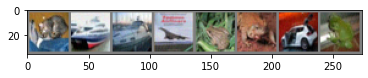

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog
Predicted:   bird   car truck  ship  deer   cat  frog  bird


In [66]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.cuda(), labels.cuda()

x_adv = fgsm_attack(net, images, labels, 8/255)

outputs_adv = net(x_adv)

# print images
imshow(torchvision.utils.make_grid(x_adv.cpu().detach()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

_, predicted = torch.max(outputs_adv, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

Looping over the test set to compute the adversarial accuracy against a FGSM adversary.

In [67]:
correct = 0
total = 0
for data in testloader:
    images, labels = data[0].cuda(), data[1].cuda()
    adv_images = fgsm_attack(net,images,labels,epsilon=8/255)
    outputs = net(adv_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 6 %


Accuracy fell from 66% to 6%. 
Looking at the perturbated images, the original class is still recognizable from a human perspective.

### 3. PGD adversary

In this part I will use a multiple step Projected Gradient Descent as the adversary. 
The findings of Madry et al. ("*Towards Deep Learning Models Resistant to Adversarial Attacks*" https://arxiv.org/abs/1706.06083) show that it is the strongest attack using only first-order local information about the network.

In [7]:
def pgd_attack(model, x_nat, y_nat, epsilon, n_steps, step_size=2/255, random_start = False):

  # Starting with a random perturbation
  if random_start:
      x = x_nat + np.random.uniform(-epsilon, epsilon, x_nat.shape)
      x = torch.clamp(x, -1, 1) # ensure valid pixel range
  else:
      x = x_nat

  # Performing PGD in the input space
  for i in range(n_steps):
    # compute gradient
    x_nat.requires_grad = True
    outputs = model(x)
    loss = criterion(outputs, y_nat)
    grad = torch.autograd.grad(outputs=loss, inputs=x)[0]

    # applying perturbation
    x = torch.add(x, step_size * grad.sign())

    x = torch.max(torch.min(x, x_nat + epsilon), x_nat - epsilon) # ensuring we 
    # remain within espilon of the original input
    x = torch.clamp(x, -1, 1) # ensure valid pixel range

  return x


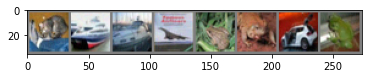

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog
Predicted:  truck   car truck  ship  deer   cat  frog  bird


In [69]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.cuda(), labels.cuda()

x_adv = pgd_attack(net, images, labels, epsilon=8/255, n_steps=10)

outputs_adv = net(x_adv)

# print images
imshow(torchvision.utils.make_grid(x_adv.cpu().detach()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

_, predicted = torch.max(outputs_adv, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

In [70]:
correct = 0
total = 0
for data in testloader:
    images, labels = data[0].cuda(), data[1].cuda()
    adv_images = pgd_attack(net,images,labels,epsilon=8/255, n_steps=10)
    outputs = net(adv_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 0 %


### 4. Adversarial training

Here during training we will compute the adversarial version of each batch and use it to train the model. (The model is trained only on adversarial examples following chat Madry et al. describe in their paper).


In [10]:
import torch.optim as optim

# Instanciating neural network
robust_net_fgsm = ConvNet()
robust_net_fgsm = robust_net_fgsm.to(device) # using the gpu

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=robust_net_fgsm.parameters(), lr=0.001) # default parameters

for epoch in range(10):  

    running_nat_loss = 0.0
    running_adv_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # sending them to the GPU at each step
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute adversarial examples 
        adv_inputs = fgsm_attack(robust_net_fgsm, inputs, labels, 8/255)
        
        # forward + backward + optimize
        nat_outputs = robust_net_fgsm(inputs)
        adv_outputs = robust_net_fgsm(adv_inputs)
        
        adv_loss = criterion(adv_outputs, labels)
        adv_loss.backward()
        optimizer.step()

        # print statistics
        nat_loss = criterion(nat_outputs, labels)
        running_nat_loss += nat_loss.item()
        running_adv_loss += adv_loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] nat loss: %.3f \nadv loss: %.3f' %
                  (epoch + 1, i + 1, running_nat_loss / 2000,running_adv_loss / 2000))
            running_nat_loss = 0
            running_adv_loss = 0

print('Finished Adversarial Training')

[1,  2000] nat loss: 1.886 
adv loss: 2.025
[1,  4000] nat loss: 1.645 
adv loss: 1.857
[1,  6000] nat loss: 1.560 
adv loss: 1.793
[2,  2000] nat loss: 1.506 
adv loss: 1.758
[2,  4000] nat loss: 1.468 
adv loss: 1.731
[2,  6000] nat loss: 1.437 
adv loss: 1.708
[3,  2000] nat loss: 1.406 
adv loss: 1.686
[3,  4000] nat loss: 1.405 
adv loss: 1.688
[3,  6000] nat loss: 1.393 
adv loss: 1.677
[4,  2000] nat loss: 1.364 
adv loss: 1.661
[4,  4000] nat loss: 1.363 
adv loss: 1.656
[4,  6000] nat loss: 1.352 
adv loss: 1.651
[5,  2000] nat loss: 1.332 
adv loss: 1.633
[5,  4000] nat loss: 1.324 
adv loss: 1.631
[5,  6000] nat loss: 1.328 
adv loss: 1.638
[6,  2000] nat loss: 1.299 
adv loss: 1.613
[6,  4000] nat loss: 1.309 
adv loss: 1.623
[6,  6000] nat loss: 1.320 
adv loss: 1.633
[7,  2000] nat loss: 1.276 
adv loss: 1.598
[7,  4000] nat loss: 1.300 
adv loss: 1.618
[7,  6000] nat loss: 1.302 
adv loss: 1.618
[8,  2000] nat loss: 1.263 
adv loss: 1.587
[8,  4000] nat loss: 1.282 
adv 

In [11]:
# computing accuracies 

correct_nat = 0
correct_fgsm = 0
correct_pgd = 0
total = 0
for data in testloader:
    images, labels = data[0].cuda(), data[1].cuda()
    fgsm_images = fgsm_attack(robust_net_fgsm,images,labels,epsilon=8/255)
    pgd_images = pgd_attack(robust_net_fgsm,images,labels,epsilon=8/255, n_steps=10)
    outputs_nat = robust_net_fgsm(images)
    outputs_fgsm = robust_net_fgsm(fgsm_images)
    outputs_pgd = robust_net_fgsm(pgd_images)
    _, predicted_nat = torch.max(outputs_nat.data, 1)
    _, predicted_fgsm = torch.max(outputs_fgsm.data, 1)
    _, predicted_pgd = torch.max(outputs_pgd.data, 1)
    total += labels.size(0)
    correct_nat += (predicted_nat == labels).sum().item()
    correct_fgsm += (predicted_fgsm == labels).sum().item()
    correct_pgd += (predicted_pgd == labels).sum().item()

print('Accuracy of the network on the 10000 test images:\nNatural accuracy %d %%\nAccuracy against FGSM %d %%\nAccuracy against 10 step pgd %d %%' % 
      (100 * correct_nat / total,100 * correct_fgsm / total ,100 * correct_pgd / total))

Accuracy of the network on the 10000 test images:
Natural accuracy 54 %
Accuracy against FGSM 38 %
Accuracy against 10 step pgd 36 %


There is a drop in the natural accuracy but a much increased robustness to adversarial examples. 
This also point to the PGD as the strongest adversary.